# Zernike 3D 

Function $f(r, \theta, \phi)$ determined in the unit ball can be expanded in the basis of the Zernike 3D functions $Z_{n,l}^{m}(r, \theta, \phi)$ with $n, l, n \in \mathbb{Z}^{+}$, $n \geq l, m \in [-l, l]$ and $n -l$ is even number:

$
\begin{align*}
f(r, \theta, \phi) &= \sum_{n=0}^{n_\text{max}} \sum_{l = mod(n, 2)}^{n_\text{max}} \sum_{m = -l}^{l} c_{n, l}^{m} Z_{n,l}^{m}(r, \theta, \phi), \\
Z_{n,l}^{m}(r, \theta, \phi) &= R_{n, l}(r) Y_{l}^{m}(\theta, \phi), \\
R_{n, l}(r) &= \sum_{\nu = 0}^{(n-l)/2} Q_{l, \nu} r^{2 \nu + l}, \\
Q_{l, \nu} = \dfrac{(-1)^{k + \nu}}{4^{k}} \sqrt{\dfrac{2l + 4 k + 3}{3}} \dfrac{ \binom{2 k}{k} \binom{k}{\nu} \binom{2 (k + l + \nu)+1}{2 k} }{\binom{k + l + \nu}{k}}
\end{align*}
$

where $k = (n - l) / 2$ and $c_{n, l}^{m} = 3 \int_{-1}^{1} \int_{-1}^{1} \int_{-1}^{1} f(x, y, z) Z_{n,l}^{m}(x, y, z) \mathrm{d}x \mathrm{d}y \mathrm{d}z / (4 \pi)$. The transition from spherical to cartesian coordinates was performed as $r = \sqrt{x^2 + y^2 + z^2}$, $\theta = \arctan(\sqrt{x^2 + y^2} / z)$ and $\phi = \arctan{y / x}$.

Coeffitients $c_{n, l}^{m}$ characterize geometrical properties of the function $f(\bullet)$ and are called Zernike 3D moments.

In case of $f$ determined on the grid of shape $(N, N, N)$, i.e. 3D image, coeffitients $c_{n, l}^{m}$ reads

$
\begin{align*}
c_{n, l}^{m} = \dfrac{1}{N_0} \sum_{i=1}^{N} \sum_{j=1}^{N} \sum_{k=1}^{N} f_{ijk} Z_{n,l}^{m}(2 i/N - 1 , 2 j/N - 1, 2 k/N - 1),
\end{align*}
$
where $N_0$ is sum of $Z_{0,0}^{0}$ 3D pixels (aka voxels).

Note, $c_{n, l}^{m}$ is not invariant with respect to rotations. Rotationally invariant moment can be obtained assembling 
all $2 l + 1$ harmonics with different $m$ for given $n, l$, i.e.

$
\begin{align*}
C_{n, l} = \left\Vert (c_{n, l}^{-l}, c_{n, l}^{-l+1}, ..., 0, ..., c_{n, l}^{l-1}, c_{n, l}^{l}) \right\Vert
\end{align*}
$

### References

[Marcin Novotni and Reinchard Klein, “Shape retrieval using 3D Zernike descriptors”](https://www.sciencedirect.com/science/article/pii/S0010448504000077)


In [247]:
import numpy as np
import matplotlib.pyplot as plt

from mayavi import mlab
from scipy.special import sph_harm
from math import factorial as fact
from math import pi, sqrt, sin, cos, atan2
from numpy.linalg import norm

def binomial(n, k): return fact(n)  / (fact(k) * fact(n - k))

In [302]:
class Zernike3D:
    def __init__(self, IMG3D: np.array):
        self.IMG3D = IMG3D

    def radial(self, n: int, l: int) -> ():
        """Radial Zernike polynomials normalized for 3D case for given order n, l."""
        # normalization factor
        Q = lambda k, l, nu: ((-1)**(k + nu) / 4**k) *\
                             sqrt((2 * l + 4 * k + 3) / 3) *\
                             (binomial(2 * k, k) * binomial(k, nu) * binomial(2 * (k + l + nu) + 1, 2 * k) / binomial(k + l + nu, k))
        if (n - l) % 2 != 0: 
            return lambda r: 0
        else:
            return lambda r: sum([Q((n - l) / 2, l, nu) * r**(2 * nu + l) for nu in range((n - l) // 2 + 1)]) 
    
    def zfunction(self, n: int, l: int, m: int) -> ():
        """Zernike 3D function of given order n, l, m."""
        # check parameters validity
        # init radial part
        R = self.radial(abs(n), abs(l))
        # 3D Zernike function
        def Z(x, y, z) -> ():
            if x**2 + y**2 + z**2 > 1:
                return 0
            else:
                r = sqrt(x**2 + y**2 + z**2)
                theta = atan2(sqrt(x**2 + y**2), z)
                phi = atan2(y, x)
                return  R(r) * sph_harm(m, l, phi, theta)
        return Z

    def zfunction_on_grid(self, n: int, l: int, m: int) -> np.array:
        """Calculate 3D Zernike function on the grid with shape of the given 3D image."""
        # discretization parameters
        max_x, max_y, max_z = self.IMG3D.shape[:3]
        dx, dy, dz = 2 / (max_x - 1), 2 / (max_y - 1), 2 / (max_z - 1)
        x, y, z = np.arange(-1, 1 + dx, dx), np.arange(-1, 1 + dy, dy), np.arange(-1, 1 + dz, dz) 
        Z = self.zfunction(n, l, m)
        Z_on_grid = np.array([[[np.real(Z(xi, yi, zi)) for xi in x] for yi in y] for zi in z])
        return Z_on_grid

    def allowed_modes(self, nmax: int) -> list:
        """Generate list of (n, l, m) allowed modes for given maximum order of n: nmax."""
        return [(n, l, m) for n in range(nmax + 1) for l in range(nmax + 1) for m in range(-l, l+1) if (n - l) % 2 == 0 and n >= l]

    def descriptor(self, nmax: int) -> list:
        """Zernike 3D descriptor vector of given order for 3D image."""
        # determine the Zernike functions on the grid of the given 3D image
        # excluding points with zero x, y, z uncertainty 0 / 0 or inf / 0
        vector = []
        # calculate the normalization factor: number of pixels in the unit sphere, i.e. mode 0,0,0
        norm_factor = np.sum(np.real(self.zfunction_on_grid(0,0,0)))
        # calculate allowed modes for given n
        allowed_modes = self.allowed_modes(nmax)
        
        for ni, li, mi in allowed_modes:
            # calculation of the 3D Zernike function on the grid 
            A = self.zfunction_on_grid(ni, li, mi) # <- most computationally comlex part
            component = np.sum(A * self.IMG3D) / norm_factor
            vector.append((ni, li, mi, component))
        return vector

    def invariant_descriptor(self, nmax: int) -> list:
        """Rotationally invariant Zernike 3D descriptor."""
        # agregate all m harmonics with n,l into vector
        # calculate norm of the vector to get the invariant descriptor of 3D image 
        descriptor = self.descriptor(nmax)
        descriptor_ri = [ [descriptor[0][0], descriptor[0][1], [descriptor[0][3]]] ]
        # assemble vectors [[n,l, A], ...], where A composed of Znlm with m = [-l, l]
        for n, l, m, Z in descriptor[1:]:
            prev_n, prev_l = descriptor_ri[-1][:2]
            if n == prev_n and l == prev_l:
                descriptor_ri[-1][2] += [Z]
            else:
                descriptor_ri.append([n, l, [Z]])
        # calculate norm of A vectors 
        descriptor_ri_norm = [(n, l, norm(Z)) for n, l, Z in descriptor_ri]
        return descriptor_ri_norm

    def reconstruct(self, descriptor: list, add_img3d: bool=False) -> np.array:
        """Reconstruct given 3D image from descriptor composed of Zernike 3D moments."""
        res = np.zeros(self.IMG3D.shape[:3])

        for n, l, m, coeff in descriptor:
            res += coeff * self.zfunction_on_grid(n, l, m)
        return res
        
    def plot_radial(self, n: int, l: int):
        """Plot radial Zernike polynom of order n."""
        R = self.radial(n, l)
        x = np.arange(0, 1, 0.01)
        y = np.array([R(r) for r in x])

        plt.figure(dpi=100)
        plt.plot(x, y)
        plt.xlim(0, 1.1)
        plt.ylabel(f'$R_{n}^{l}(r)$')
        plt.xlabel('r')
        plt.show()

    def plot_zfunction_slice(self, n: int, l: int, m: int, lattitude: int=1):
        """Plot 3D Zernike moment slice at the level lattitude * grid_step."""
        Z = self.zfunction(n, l, m)
        d = 0.01
        x = np.concatenate([np.arange(-1, -d, d), np.arange(d, 1 + d, d)])
        cut_const_z = np.array([[np.real(Z(xi, yi, lattitude * d)) for xi in x] for yi in x])
        cut_const_x = np.array([[np.real(Z(lattitude * d, yi, zi)) for zi in x] for yi in x])

        plt.figure(dpi=100)
        plt.subplot(1,2,1)
        plt.imshow(cut_const_z, cmap='rainbow')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        plt.title('xy')

        plt.subplot(1,2,2)
        plt.imshow(cut_const_x, cmap='rainbow')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
        plt.title('zy')
        plt.show()

    def plot_zfunction_3d(self, n: int, l: int, m: int, add_img3d: bool=False):
        """Plot 3D zernike moment in 3D as density plot."""
        # calculate 3D Zernike function on the grid
        mode = self.zfunction_on_grid(n, l, m) 
        mode = np.abs(mode)
        # mode[mode != 0] +=  np.abs(np.min(mode))
        
        mlab.pipeline.volume(mlab.pipeline.scalar_field(mode), vmin=0, vmax=0.8 * np.max(mode))
        if add_img3d:
            mlab.pipeline.volume(mlab.pipeline.scalar_field(self.IMG3D))
        mlab.axes()
        mlab.show()

    def plot_img3d(self):
        """Plot voxelized 3D image."""
        mlab.pipeline.volume(mlab.pipeline.scalar_field(self.IMG3D))
        mlab.axes()
        mlab.show()
    
    def plot_denisty_plot_3d(self, func_on_grid: np.array, add_img3d: bool=False):
        """Plot 3D density plot of arbitrary function on grid."""
        mlab.pipeline.volume(mlab.pipeline.scalar_field(func_on_grid), vmin=0, vmax=0.8 * np.max(func_on_grid))
        if add_img3d:
            mlab.pipeline.volume(mlab.pipeline.scalar_field(self.IMG3D))
        mlab.axes()
        mlab.show()

def make_3D_img_from_spheres(spheres: list, val: float=1, ds: float=0.1):
    """Make 3D image from spheres: (x,y,z,r)."""
    smpl = np.arange(-1, 1 + ds, ds)
    N = smpl.shape[0]
    grid = np.zeros((N, N, N))

    for xi, yi, zi, ri in spheres:
        for i, x in enumerate(smpl):
            for j, y in enumerate(smpl):
                for k, z in enumerate(smpl):
                    if (x - xi)**2 + (y - yi)**2 + (z - zi)**2 <= ri**2:
                        grid[i,j,k] = val
    return grid

In [303]:
test_structure1 = [(0, 0, 0, 0.2)]
test_structure2 = [(0.5, 0, 0, 0.2), (-0.5, 0, 0, 0.2), (0,0.5,0,0.3), (0,-0.5,0,0.3)] 

test_3d_image = make_3D_img_from_spheres(test_structure2, ds=0.05)

zen = Zernike3D(test_3d_image)


In [304]:
zen.plot_img3d()
#zen.plot_radial(1, 1)

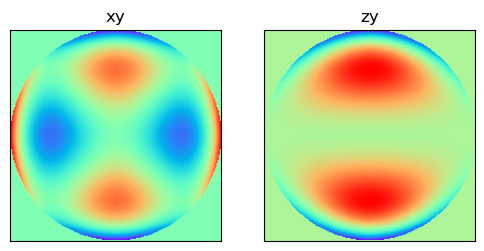

In [301]:
zen.plot_zfunction_slice(4, 2, 2, 1)


In [210]:
zen.plot_zfunction_3d(4,0,0,add_img3d=True)


In [287]:
descriptor = zen.descriptor(10)

print(f'Total number of descriptor components: {len(descriptor)}')
#for _ in descriptor:
#    print(_)

Total number of descriptor components: 455


In [292]:
reconstrucuted_IMG3D = zen.reconstruct(descriptor, add_img3d=True)

In [293]:
zen.plot_denisty_plot_3d(reconstrucuted_IMG3D)

## Test orthogonality

In [286]:
moment = lambda n1, l1, m1, n2, l2, m2: np.sum(np.real(zen.zfunction_on_grid(n1, l1, m1)) * np.real(zen.zfunction_on_grid(n2, l2, m2))) / np.sum(np.real(zen.zfunction_on_grid(0,0,0)))
modes = zen.allowed_modes(1)


print('n1\tl1\tm1\tn2\tl2\tm2\tRe[Zn1l1m1] * Re[Zn2l2m2]')
for n1, l1, m1 in modes:
    for n2, l2, m2 in modes:
        print(f'{n1}\t{l1}\t{m1}\t{n2}\t{l2}\t{m2}\t{moment(n1,l1,m1,n2,l2,m2)}')


n1	l1	m1	n2	l2	m2	Re[Zn1l1m1] * Re[Zn2l2m2]
0	0	0	0	0	0	0.2820947917738781
0	0	0	1	1	-1	-5.0776450279566904e-05
0	0	0	1	1	0	-7.180874463451429e-05
0	0	0	1	1	1	5.0776450279566904e-05
1	1	-1	0	0	0	-5.0776450279566904e-05
1	1	-1	1	1	-1	0.1406804106762509
1	1	-1	1	1	0	2.86836870270652e-05
1	1	-1	1	1	1	-0.1406804106762509
1	1	0	0	0	0	-7.180874463451429e-05
1	1	0	1	1	-1	2.86836870270652e-05
1	1	0	1	1	0	0.2813608213525018
1	1	0	1	1	1	-2.86836870270652e-05
1	1	1	0	0	0	5.0776450279566904e-05
1	1	1	1	1	-1	-0.1406804106762509
1	1	1	1	1	0	-2.86836870270652e-05
1	1	1	1	1	1	0.1406804106762509



## Test rotational invariance

In [264]:
test_structure_rot = [(0.5, 0, 0, 0.2), (-0.5, 0, 0, 0.2)]
test_structure_rot90 = [(0, 0.5, 0, 0.2), (0, -0.5, 0, 0.2)] 
test_structure_rot90theta = [(0, 0, 0.5, 0.2), (0, 0, -0.5, 0.2)] 

test_3d_image_rot = make_3D_img_from_spheres(test_structure_rot, ds=0.05)
test_3d_image_rot90 = make_3D_img_from_spheres(test_structure_rot90, ds=0.05)
test_3d_image_rot90theta = make_3D_img_from_spheres(test_structure_rot90theta, ds=0.05)

zen1 = Zernike3D(test_3d_image_rot)
zen2 = Zernike3D(test_3d_image_rot90)
zen3 = Zernike3D(test_3d_image_rot90theta)


In [260]:
zen1.plot_img3d()

In [258]:
zen2.plot_img3d()

In [265]:
zen3.plot_img3d()

In [267]:
ri_desc1 = zen1.invariant_descriptor(2)
ri_desc2 = zen2.invariant_descriptor(2)
ri_desc3 = zen3.invariant_descriptor(2)


In [294]:
print(f'n\tl\tst1\t\t\tst2\t\t\tst3')
for i in range(len(ri_desc1)):
    print(f'{ri_desc1[i][0]}\t{ri_desc1[i][1]}\t{ri_desc1[i][2]}\t{ri_desc2[i][2]}\t{ri_desc3[i][2]}')

n	l	st1			st2			st3
0	0	0.015218693828639903	0.015218693828639903	0.015218693828639907
1	1	3.789427993007622e-05	3.78942799300759e-05	3.789427993007574e-05
2	0	0.019002542014483825	0.019002542014483828	0.019002542014483828
2	2	0.012995433865357214	0.012995433865357215	0.012995433865357215


## Test influence of 3D image voxels values on the expansion coeffitients

Value of density, i.e. voxel value influences on the value of the expansion coeffitients.

In [305]:
test_structure_geom = [(0.5, 0, 0, 0.2), (-0.5, 0, 0, 0.2), (0,0.5,0,0.3), (0,-0.5,0,0.3)] 

test_3d_image_dens1 = make_3D_img_from_spheres(test_structure_geom, ds=0.05)
test_3d_image_dens01 = make_3D_img_from_spheres(test_structure_geom, val=0.1, ds=0.05)

zen_dens1 = Zernike3D(test_3d_image_dens1)
zen_dens01 = Zernike3D(test_3d_image_dens01)


In [306]:
zen_dens1.plot_img3d()

In [308]:
zen_dens01.plot_zfunction_3d(4, 2, 2, add_img3d=True)

In [311]:
descriptor_dens1 = zen_dens1.descriptor(5)


In [312]:
descriptor_dens01 = zen_dens01.descriptor(5)

In [320]:
# rotationally invariant descriptors 
ri_descriptor_dens1 = zen_dens1.invariant_descriptor(5)

In [321]:
ri_descriptor_dens01 = zen_dens01.invariant_descriptor(5)

In [322]:
print('n\tl\tDens1\t\t\tDens01')
for i in range(len(ri_descriptor_dens1)):
    print(f'{ri_descriptor_dens1[i][0]}\t{ri_descriptor_dens1[i][1]}\t{ri_descriptor_dens1[i][2]}\t{ri_descriptor_dens01[i][2]}')

n	l	Dens1			Dens01
0	0	0.0695626123427202	0.006956261234272019
1	1	0.00026525995951063523	2.652599595106335e-05
2	0	0.08052570287618739	0.00805257028761874
2	2	0.04136534980872191	0.004136534980872191
3	1	0.00045061452833452463	4.506145283345275e-05
3	3	0.0002480953584814384	2.4809535848143837e-05
4	0	0.013347096958543416	0.0013347096958543415
4	2	0.09265904627119834	0.009265904627119834
4	4	0.02204635666289009	0.002204635666289009
5	1	0.00026355359326303004	2.635535932630297e-05
5	3	0.0006869973523802791	6.869973523802799e-05
5	5	0.0001741985168601036	1.7419851686010393e-05


In [313]:
print('n\tl\tm\tDens1\t\t\tDens01')
for i in range(len(descriptor_dens1)):
    print(f'{descriptor_dens1[i][0]}\t{descriptor_dens1[i][1]}\t{descriptor_dens1[i][2]}\t{descriptor_dens1[i][3]}\t{descriptor_dens01[i][3]}')

n	l	m	Dens1			Dens01
0	0	0	0.0695626123427202	0.006956261234272019
1	1	-1	-0.0001326299797553175	-1.3262997975531754e-05
1	1	0	-0.00018756711614723932	-1.875671161472369e-05
1	1	1	0.0001326299797553175	1.3262997975531754e-05
2	0	0	-0.08052570287618739	-0.00805257028761874
2	2	-2	-0.028354453415718236	-0.0028354453415718236
2	2	-1	1.0025884080695399e-05	1.0025884080695416e-06
2	2	0	-0.010155880402651212	-0.0010155880402651209
2	2	1	-1.0025884080695448e-05	-1.0025884080695361e-06
2	2	2	-0.028354453415718243	-0.0028354453415718244
3	1	-1	0.0002464493796380595	2.4644937963805956e-05
3	1	0	0.0002856201318152789	2.8562013181528343e-05
3	1	1	-0.0002464493796380595	-2.4644937963805956e-05
3	3	-3	0.0001295450336498466	1.2954503364984665e-05
3	3	-2	0.00010527178284723237	1.0527178284723186e-05
3	3	-1	9.035819336771634e-06	9.035819336771681e-07
3	3	0	7.523221931799167e-05	7.523221931799251e-06
3	3	1	-9.03581933677162e-06	-9.035819336771639e-07
3	3	2	0.00010527178284723237	1.0527178284723208e-05
3

In [314]:
reconstrucuted_IMG3D_dens1 = zen.reconstruct(descriptor_dens1, add_img3d=True)

reconstrucuted_IMG3D_dens01 = zen.reconstruct(descriptor_dens01, add_img3d=True)

In [315]:
zen.plot_denisty_plot_3d(reconstrucuted_IMG3D_dens1)

In [316]:
zen.plot_denisty_plot_3d(reconstrucuted_IMG3D_dens01)